## Sentiment analysis on words and frequency found in the Jeopardy "Questions", "Categories", and "Answers".  

In [2]:
# Initial imports
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from textblob import TextBlob
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'textblob'

In [3]:
# Loading data
wordsSQL = pd.read_csv("./Resources/wordsSQL.csv").iloc[:,1:]
wordsSQL = wordsSQL.dropna().reset_index()

wordsSQL.info

<bound method DataFrame.info of       index Question_Word  Question_Count Answer_Word  Answer_Count  \
0         0          star           439.0        star          63.0   
1         1           war           644.0         war         183.0   
2         2         comic           105.0       comic           5.0   
3         3          book           790.0        book          43.0   
4         4     publisher            32.0   publisher           1.0   
...     ...           ...             ...         ...           ...   
3313   3313         girth             1.0       girth           1.0   
3314   3314    surrealism             1.0  surrealism           3.0   
3315   3315      memoriam             1.0    memoriam           1.0   
3316   3316      bonnaroo             3.0    bonnaroo           1.0   
3317   3317         dunce             1.0       dunce           4.0   

     Category_Word  Category_Count  
0             star             148  
1              war             287  
2   

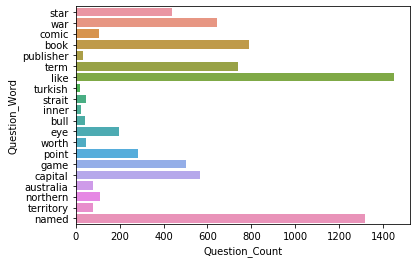

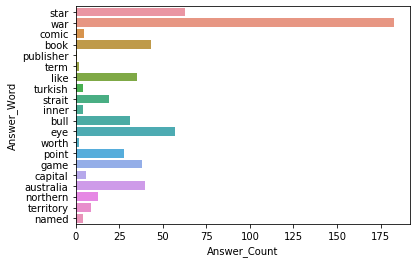

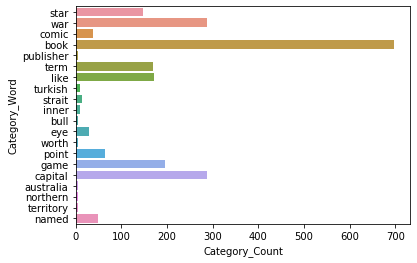

In [3]:
# Graph of word count frequencies
sns.barplot(data= wordsSQL.iloc[0:20], x= 'Question_Count', y= 'Question_Word')
plt.show()

sns.barplot(data= wordsSQL.iloc[0:20], x= 'Answer_Count', y= 'Answer_Word')
plt.show()

sns.barplot(data= wordsSQL.iloc[0:20], x= 'Category_Count', y= 'Category_Word')
plt.show()



In [4]:
# Define features set
sent = wordsSQL.copy()
sent.drop(['index', 'Category_Word', 'Answer_Word'], axis = 1, inplace = True)

sent

,Question_Word,Question_Count,Answer_Count,Category_Count
0,star,439.0,63.0,148
1,war,644.0,183.0,287
2,comic,105.0,5.0,37
3,book,790.0,43.0,698
4,publisher,32.0,1.0,5
...,...,...,...,...
3313,girth,1.0,1.0,5
3314,surrealism,1.0,3.0,5
3315,memoriam,1.0,1.0,5
3316,bonnaroo,3.0,1.0,5


In [5]:
# Applying text blob sentiment to features
def polarity(t):
    a = TextBlob(t).sentiment
    return a[0]

def subjectivity(t):
    a = TextBlob(t).sentiment
    return a[1]

sent['polarity'] = sent.apply(lambda t: polarity(t['Question_Word']), axis=1)
sent['subjectivity'] = sent.apply(lambda t: subjectivity(t['Question_Word']), axis=1)



In [6]:
#Issue a rating system for classification for polarity
Rating_polarity = []

for row in range(0, len(sent['polarity'])):

    if sent.loc[row, 'polarity'] >=0.5 <= 1:
        Rating_polarity.append(1)
        
    elif sent.loc[row, 'polarity'] >= 0 < 0.99:
        Rating_polarity.append(2)
        
    elif sent.loc[row, 'polarity'] <= -.1 > -0.99:
        Rating_polarity.append(3)
    
    elif sent.loc[row, 'polarity'] == -1:
        Rating_polarity.append(4)
       
    else: 
        Rating_polarity.append(None)


sent["Rating_p"] = Rating_polarity

In [7]:
#Transform target data for polarity to a vertical vector and verify the shape
y_p = sent['Rating_p'].values.reshape(-1,1)

num_rows, num_cols = y_p.shape
print(num_rows, num_cols)

3318 1


In [8]:
#Drop any meaningless data
y_p[np.isnan(y_p)] = 0



In [9]:
#Define features set for polarity
X_p = sent.copy()
X_p.drop(['Rating_p', 'Question_Word'], axis=1, inplace = True)

X_p.head(2)

,Question_Count,Answer_Count,Category_Count,polarity,subjectivity
0,439.0,63.0,148,0.0,0.0
1,644.0,183.0,287,0.0,0.0


In [10]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_p, y_p, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [11]:
# Create a random forest classifier
word_count_model_p = RandomForestClassifier(n_estimators=3000, random_state=78)

# Fitting the model
word_count_model_p = word_count_model_p.fit(X_train_scaled, y_train.ravel())

# Making predictions using the testing data
predictions_p = word_count_model_p.predict(X_test_scaled)

In [12]:
# Calculating the confusion matrix for polarity
cm_p = confusion_matrix(y_test, predictions_p)
cm_df_p = pd.DataFrame(cm_p, \
        index=["Actual Rating: 1", "Actual Rating: 2", "Actual Rating: 3", "Actual Rating: 4"], \
        columns=["Predicted Rating: 1", "Predicted Rating: 2", "Predicted Rating: 3", "Predicted Rating: 4"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_p)

In [13]:
# Displaying results
print("Confusion Matrix for Polarity")
display(cm_df_p)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_p))

Confusion Matrix for Polarity


,Predicted Rating: 1,Predicted Rating: 2,Predicted Rating: 3,Predicted Rating: 4
Actual Rating: 1,2,0,0,0
Actual Rating: 2,0,11,0,0
Actual Rating: 3,0,0,796,0
Actual Rating: 4,0,0,0,21


Accuracy Score : 1.0
Classification Report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00         2
         1.0       1.00      1.00      1.00        11
         2.0       1.00      1.00      1.00       796
         3.0       1.00      1.00      1.00        21

    accuracy                           1.00       830
   macro avg       1.00      1.00      1.00       830
weighted avg       1.00      1.00      1.00       830



In [14]:
#Issue a rating system for classification for subjectivity
Rating_subjectivity=[]

for row in range(0, len(sent['subjectivity'])):

    if sent.loc[row, 'subjectivity'] >= 0.75 <=1:
        Rating_subjectivity.append(1)

    elif sent.loc[row, 'subjectivity'] >=0.5 <=0.74:
        Rating_subjectivity.append(2)
        
    elif sent.loc[row, 'subjectivity'] >=0.25 <= 0.49:
        Rating_subjectivity.append(3)
        
    elif sent.loc[row, 'subjectivity'] >= 0 <= 0.24:
        Rating_subjectivity.append(4)
       
    else: 
        Rating_subjectivity.append(None)


sent["Rating_s"] = Rating_subjectivity

In [15]:
#Transform target data for subjectivity to a vertical vector and verify the shape
y_s = sent['Rating_s'].values.reshape(-1,1)

num_rows, num_cols = y_s.shape
print(num_rows, num_cols)

3318 1


In [16]:
#Drop NaN data
y_s[np.isnan(y_s)] = 0

In [17]:
#Define feature set for subjectivity.  Removed Rating_p as to not skew results
X_s = sent.copy()
X_s.drop(['Rating_s', 'Rating_p', 'Question_Word'], axis=1, inplace = True)

X_s.head(2)


,Question_Count,Answer_Count,Category_Count,polarity,subjectivity
0,439.0,63.0,148,0.0,0.0
1,644.0,183.0,287,0.0,0.0


In [18]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X_s, y_s, random_state=78)

# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaller
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# Create a random forest classifier
word_count_model_s = RandomForestClassifier(n_estimators=3000, random_state=78)

# Fitting the model
word_count_model_s = word_count_model_s.fit(X_train_scaled, y_train.ravel())

# Making predictions using the testing data
predictions_s = word_count_model_s.predict(X_test_scaled)

In [21]:
# Calculating the confusion matrix for subjectivity
cm_s = confusion_matrix(y_test, predictions_s)
cm_df_s = pd.DataFrame(cm_s, \
            index=["Actual Rating: 1", "Actual Rating: 2", "Actual Rating: 3", "Actual Rating: 4"], \
            columns=["Predicted Rating: 1", "Predicted Rating: 2", "Predicted Rating: 3", "Predicted Rating: 4"])
        

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions_s)

In [22]:
# Displaying results
print("Confusion Matrix for Subjectivity")
display(cm_df_s)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions_s))

Confusion Matrix for Subjectivity


,Predicted Rating: 1,Predicted Rating: 2,Predicted Rating: 3,Predicted Rating: 4
Actual Rating: 1,17,0,0,0
Actual Rating: 2,0,18,0,0
Actual Rating: 3,0,3,17,0
Actual Rating: 4,0,0,1,774


Accuracy Score : 0.9951807228915662
Classification Report
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        17
           2       0.86      1.00      0.92        18
           3       0.94      0.85      0.89        20
           4       1.00      1.00      1.00       775

    accuracy                           1.00       830
   macro avg       0.95      0.96      0.95       830
weighted avg       1.00      1.00      1.00       830



In [25]:
#Determine the polarity and subjectivity values based on the polarity rating
sent.groupby('Rating_p').median()[['polarity', 'subjectivity']]

,polarity,subjectivity
Rating_p,,
0.0,-0.05,0.207143
1.0,0.60,0.900000
2.0,0.00,0.000000
3.0,-0.30,0.541667


In [24]:
#Determine the polarity and subjectivity values based on the subjectivity rating
sent.groupby('Rating_s').median()[['polarity', 'subjectivity']]

,polarity,subjectivity
Rating_s,,
1,0.30,0.950
2,0.16,0.540
3,0.00,0.375
4,0.00,0.000
